# Gaussian Processes for Regression 

This tutorial is intended to help build intuition and to aid in the visualisation of Gaussian processes for regression. The code is written in Python (but you won't need to know any Python to successfully complete the tutorial). We are fist going to implement Gaussian processes from scratch in order to see how the various parts are constructed. In practice, there are many packages available for modelling with Gaussian processes (including in R). Later you will see how we can use scikit-learn's simple yet powerful Gaussian process implementation.

To run a piece of code in this tutorial, simply click on the cell to select it, then press SHIFT+ENTER or press the play button in the toolbar above. To get started we first need to do some imports, select the following cell and press SHIFT+ENTER.

In [37]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)
#

## Stochastic processes

A Gaussian process is a type of [Stochastic process](https://en.wikipedia.org/wiki/Stochastic_process), where a stochastic process typically describes a system which is randomly changing over time due to uncertainty. Even if we start from the exact same initial condition, there are several directions in which the process can evolve.

A familiar example of a stochastic process is the model of [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion), which describes the random motion of a particle suspended in a fluid caused by other particles randomly bumping into it. Let's begin by getting a feel for what this looks like. 

In the following, we simulate this process over time $t$ in 1 dimension $d$ by starting out at position 0 and moving the particle over a certain amount of time $\Delta t$ with a random distance $\Delta d$ from the previous position. The random distance is sampled from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with mean $0$ and variance $\Delta t$. Sampling $\Delta d$ from this normal distribution is noted as $\Delta d \sim \mathcal{N}(0, \Delta t)$. The position $d(t)$ at time $t$ evolves as $d(t + \Delta t) = d(t) + \Delta d$.

Run the below cell to simulate 5 different realisations of Brownian motion, each realisation is illustrated with a different color.

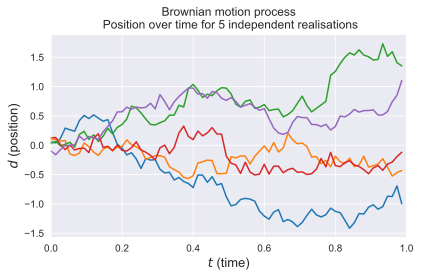

In [38]:
# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 75
delta_t = total_time / nb_steps
nb_processes = 5  # Simulate 5 different motions
mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively
#  making a new movement delta_d
distances = np.cumsum(
    # Move randomly from current location to N(0, delta_t)
    np.random.normal(
        mean, stdev, (nb_processes, nb_steps)),
    axis=1)

plt.figure(figsize=(6, 4))
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])
plt.title((
    'Brownian motion process\n '
    'Position over time for 5 independent realisations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.xlim([-0, 1])
plt.tight_layout()
plt.show()
#

### Activity
- Run the above code cell a few times and observe the plot to get a feel for the variability in the process

## Gaussian processes

As we have seen in the lecture, a Gaussian process can be viewed as a distribution over functions $f(x)$, where the distribution is defined by a mean function $m(x)$ (often chosen to be zero everywhere) and [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix) covariance function $k(x,x')$, where the $(x,x')$ are all possible pairs of input locations. We can denote this as:

$$f(x) \sim \mathcal{GP}(m(x),k(x,x'))$$

While the multivariate Gaussian distribution captures a finite number of jointly distributed Gaussians, the specification of a mean and covariance function for a Gaussian process allows us to extend the concept of the Gaussian distribution to infinite dimensionality. 

### Specifying the covariance function

To sample functions from the Gaussian process we need to define the mean and covariance functions. The [covariance function](https://en.wikipedia.org/wiki/Covariance_function) $k(x_a, x_b)$ populates the covariance matrix by returning the [covariance](https://en.wikipedia.org/wiki/Covariance) between each pair $x_a$ and $x_b$.

The specification of this covariance function, also known as the kernel function, implies a distribution over functions $f(x)$. By choosing a specific kernel function $k$ it is possible to set [prior](https://en.wikipedia.org/wiki/Prior_probability) information on this distribution. This kernel function needs to be [positive-definite](https://en.wikipedia.org/wiki/Positive-definite_function) in order to be a valid covariance function.

Here, we will model the covariance with the [squared exponential](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) covariance function (also known as the RBF kernel):

$$k(x_a, x_b) = \exp{ \left( -\frac{1}{2l^2} \lVert x_a - x_b \rVert^2 \right)}$$

In the following code cell we define the squared exponential covariance function which includes a length scale parameter $l$. Recall that the length scale determines how far apart points need to be before they become uncorrelated. Another way to describe the length scale is that it controls the degree of smoothness of the functions.

In [39]:
# Define the squared exponential covariance function 
def squared_exponential(xa, xb, length_scale):
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp((1/(length_scale)**2) * sq_norm)

### Sampling from prior

In practice we can't just sample a full function evaluation $f$ from a Gaussian process since that would mean evaluating $m(x)$ and $k(x,x')$ at an infinite number of points. We can however sample function evaluations $\mathbf{y}$ of a function $f$ drawn from a Gaussian process at a finite, but arbitrary, set of points $X$: $\mathbf{y} = f(X)$.

In the figure below we will sample 5 different function realisations from a Gaussian process with a squared exponential kernel before seeing any data (i.e., the prior distribution). We do this by drawing correlated samples from a 41-dimensional Gaussian $\mathcal{N}(0, k(X, X))$ with $X = [X_1, \ldots, X_{41}]$.

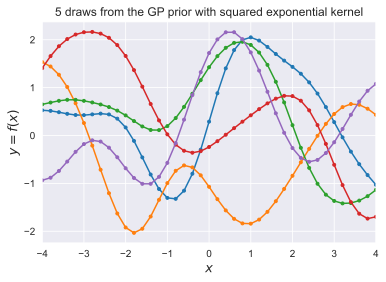

In [40]:
# Sample from the Gaussian process prior

# Length Scale
length_scale = 1

nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = squared_exponential(X, X, length_scale)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

# Plot the sampled functions
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 draws from the GP prior with squared exponential kernel'))
plt.xlim([-4, 4])
plt.show()
#

### Activity
- Experiment by changing the length scale parameter in the above code cell and seeing what effect this has on the sampled functions.
- Try setting the length scale to a small value and compare the samples to those when the length scale is longer (e.g., 0.1 vs 1).
- What happens if you set the length scale parameter very large (e.g., 100)?
- What can you conclude about the effect of the length scale parameter on the sampled functions from these experiments?

## Gaussian processes for regression

Since Gaussian processes model distributions over functions, we can use them to build [regression](https://en.wikipedia.org/wiki/Regression_analysis) models. We can treat the Gaussian process as a prior defined by the kernel function and create a [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) given some data. This posterior distribution can then be used to predict the mean and variance of the output variable $\mathbf{y}$ given the input variables $X$.


### Predictions from posterior

We want to make predictions $\mathbf{y}_2 = f(X_2)$ for $n_2$ new samples, and we want to make these predictions based on our Gaussian process prior and $n_1$ previously observed data points $(X_1,\mathbf{y}_1)$. As discussed in the lecture, we can form the joint distribution of $\mathbf{y}_1$ and $\mathbf{y}_2$ as follows: 

$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right],
\left[ \begin{array}{cc}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array} \right]
\right)
$$

We can then use the conditioning rules for Gaussians to obtain the posterior distribution for $\mathbf{y}_2$:

$$\begin{split}
p(\mathbf{y}_2 \mid \mathbf{y}_1, X_1, X_2) & =  \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) \\
\mu_{2|1} & = \mu_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{y}_1 - \mu_1) \\
          & = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1 \quad (\text{if we assume mean prior }  \mu = 0 ) \\
\Sigma_{2|1} & = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1}\Sigma_{12}
\end{split}$$

It is then possible to predict $\mathbf{y}_2$ corresponding to the input samples $X_2$ by using the mean $\mu_{2|1}$ of the resulting distribution as a prediction. 
Notice that the mean of the posterior predictions $\mu_{2|1}$ of a Gaussian process are weighted averages of the observed variables $\mathbf{y}_1$, where the weighting is based on the covariance function $k$. The variance $\sigma_2^2$ of these predictions is then the diagonal of the covariance matrix $\Sigma_{2|1}$.

The Gaussian process posterior is implemented in the `GP` method below (here, we make use of Scipy's `solve` function).

In [41]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1, length_scale)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, length_scale)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2, length_scale)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

The code below calculates the posterior distribution based on 8 observations from a sine function. The results are plotted below. The top figure shows the distribution where the red line is the posterior mean, the shaded area is the 95% prediction interval, the black dots are the observations $(X_1,\mathbf{y}_1)$.
The prediction interval is computed from the standard deviation $\sigma_{2|1}$, which is the square root of the diagonal of the covariance matrix. The bottom figure shows 5 samples from this distribution.  

Note that the distribution is quite confident of the points predicted around the observations $(X_1,\mathbf{y}_1)$, and that the prediction interval gets larger the further away it is from these points.

In [42]:
# Compute the posterior mean and covariance
length_scale = 1
# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+3, domain[1]-3, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, squared_exponential)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

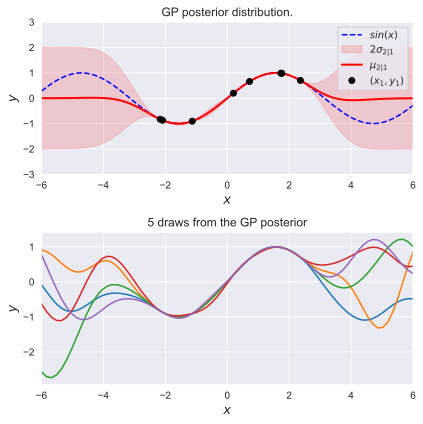

In [43]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('GP posterior distribution.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 draws from the GP posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

### Activity
- What can you say about the confidence of the estimates near the data vs far from the data?
- As before, experiment by changing the length scale parameter and re-computing the posterior a few times (e.g., try 0.5 vs 1).
- Do the results make sense given your previous conclusions?
- What happens to the uncertainties as you change the length scale?
- Can you explain this?

### Noisy observations

The predictions made above assume that the observations $f(X_1) = \mathbf{y}_1$ come from a noiseless distribution. We can see this in the plot above because the posterior variance becomes zero at the observations $(X_1,\mathbf{y}_1)$.
We can instead make predictions from noisy observations $f(X_1) = \mathbf{y}_1 + \epsilon$, by modelling the noise $\epsilon$ as Gaussian noise with variance $\sigma_\epsilon^2$.

To do this, we simply add the noise to the covariance kernel of our observations like so:

$$
\Sigma_{11} = k(X_1,X_1) + \sigma_\epsilon^2 I
$$

Where $I$ is the identity matrix. Note that the noise only changes kernel values on the diagonal (white noise is independently distributed). The Gaussian process posterior with noisy observations is implemented in the `GP_noise` method below.

In [44]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, σ_noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1, length_scale) + ((σ_noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, length_scale)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2, length_scale)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [45]:
# Compute the posterior mean and covariance

length_scale = 1
σ_noise = 0.8  # The standard deviation of the noise
# Add noise kernel to the samples we sampled previously
y1 = y1 + ((σ_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, squared_exponential, σ_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

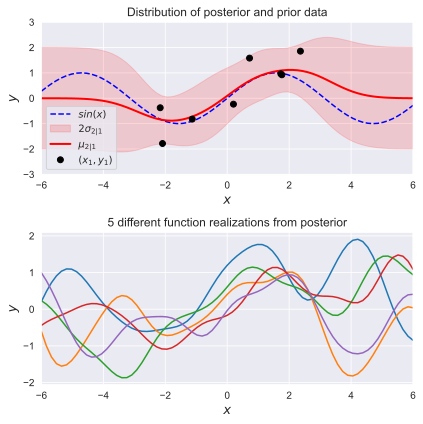

In [46]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

Notice that the uncertainty no longer collapses at the data points.

To conclude we've implemented a Gaussian process and illustrated how to make predictions using the posterior distribution.

Key points to take away are:
* A Gaussian process is a distribution over functions fully specified by a mean and covariance function.
* Every finite set of the Gaussian process distribution is a multivariate Gaussian.
* The posterior predictions of a Gaussian process are weighted averages of the observed data where the weighting is based on the covariance and mean functions.

## Gaussian process regression with scikit-learn

Now we are going to see how we can perform the same operations using scikit-learn's simple yet powerful GaussianProcessRegressor module. In this example, instead of having to choose a value for the length scale of the kernel function, we are going to learn this automatically from the data using maximum likelihood. We will first look at a noise-free case followed by a noisy case with known noise-level per datapoint.

First we will generate a synthetic dataset from a true generative process given by $f(x) = x\sin{x}$. Run the cell below to see what this looks like.

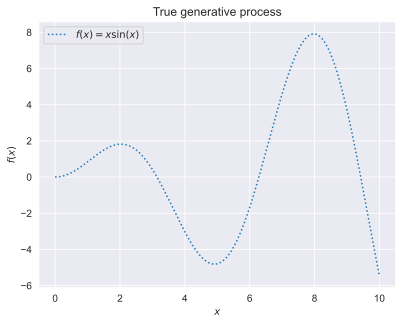

In [47]:
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

Now, we generate samples as training data and fit a Gaussian process on these samples. We will again use a squared exponential covariance function (RBF).

In [48]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [49]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

During the fitting process the hyperparameters of the kernel function are optimised. Next, we can compute the mean prediction and plot the 95% confidence interval.

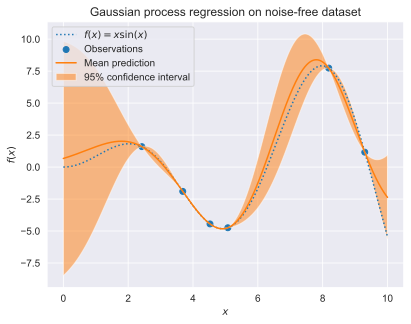

In [50]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

We again see that for a prediction made on a data point close to the one from the training set, the 95% confidence has a small amplitude. Whenever a sample falls far from the training data, our model’s prediction is less precise (higher uncertainty).

## Example with noisy targets

Now, we add some random Gaussian noise to the target with an arbitrary standard deviation and fit the model as before.

In [51]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

Let’s plot the mean prediction and the uncertainty region.

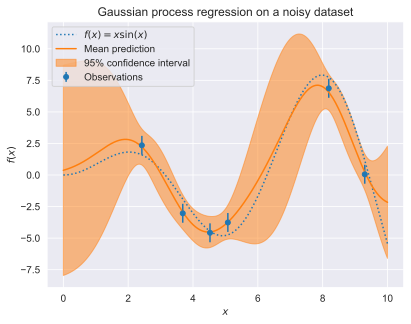

In [52]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

## Forecasting of CO2 level on Mona Loa dataset using Gaussian process regression

In this final example we see how we can use a Gaussian process to model much more complex data by combining different kernel functions (sometimes called kernel engineering). The data consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppm)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001. The objective is to model the CO2 concentration as a function of time and extrapolate for years after 2001. First let's plot the data.

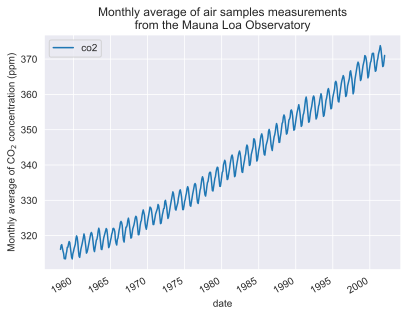

In [53]:
import pandas as pd
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True)
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
try:
    co2_data_resampled_monthly = co2_data.resample("ME")
except ValueError:
    # pandas < 2.2 uses M instead of ME
    co2_data_resampled_monthly = co2_data.resample("M")


co2_data = co2_data_resampled_monthly.mean().dropna(axis="index", how="any")
co2_data.plot()
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

Next, we form the covariance function by combining multiple kernels. The details aren't important here, but we include components to model various attributes of the data include a long term trend, a seasonal (periodic) component and the noise.

In [54]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel

X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)

Now we fit the model as before and we can use the predictions to extrapolate into the future

In [55]:
y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

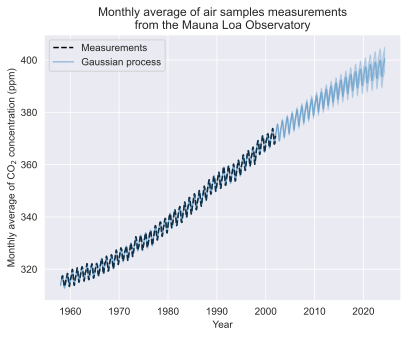

In [56]:
import datetime

import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)